In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

2024-08-30 14:03:53.642741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 14:03:53.656430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 14:03:53.660550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 14:03:53.670599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:03:54.522016: W tensorflow/compiler/tf2

In [2]:
from preprocessamento import *

csv_file = 'Datasets_csv/df_PUC.csv'
train, teste, val, _, _, _ = preprocessamento(csv_file, 0.6, 0.2, 0.2, True)

x_train, _ = next(train)
x_test, _ = next(teste)
x_val, _ = next(val)

shape = x_train.shape[1:]
print(shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)



Found 600 validated image filenames.
Found 200 validated image filenames.
Found 200 validated image filenames.


(256, 256, 3)
(32, 256, 256, 3)
(32, 256, 256, 3)


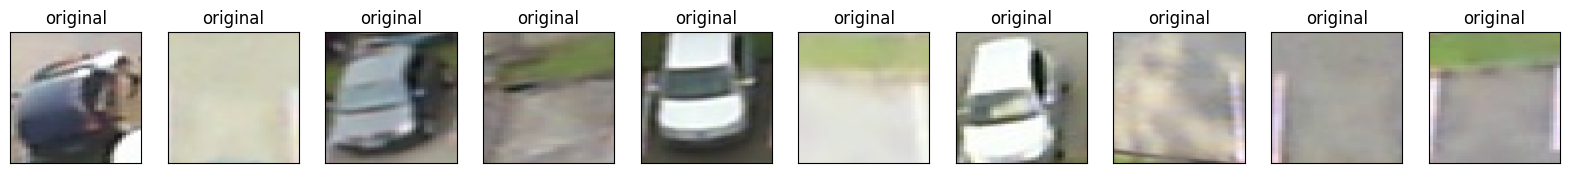

In [3]:
import matplotlib.pyplot as plt
import numpy as np

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    
    normalized_image = x_test[i]
    
    plt.imshow(normalized_image)
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [4]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

I0000 00:00:1725037435.715367  296741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725037435.747106  296741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725037435.747254  296741 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725037435.748392  296741 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
autoencoder = Autoencoder(latent_dim=latent_dim)

In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
checkpoint_path = 'weights_parciais/weights-improvement-{epoch:02d}-{loss:.2f}.weights.h5'
cp_callback = ModelCheckpoint(filepath=checkpoint_path, 
                                  save_weights_only=True, 
                                  monitor='loss',
                                  mode='max', 
                                  save_best_only=True, 
                                  verbose=1)

In [8]:
autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=32,
                shuffle=True,
                callbacks=[cp_callback],
                validation_data=(x_test, x_test))

Epoch 1/2000


I0000 00:00:1725037437.368530  296809 service.cc:146] XLA service 0x7ad094004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725037437.368549  296809 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-08-30 14:03:57.406060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-30 14:03:57.464619: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0482

I0000 00:00:1725037438.664540  296809 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: loss improved from -inf to 0.04815, saving model to weights_parciais/weights-improvement-01-0.05.weights.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0482 - val_loss: 0.0474
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0481
Epoch 2: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0481 - val_loss: 0.0474
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0481
Epoch 3: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0481 - val_loss: 0.0474
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0481
Epoch 4: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.0481 - val_loss: 0.0474
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0481
Epoch 5: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0481 - val_loss: 0.0474
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0481
Epoch 6: loss did not 

2024-08-30 14:06:00.370920: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50331648 bytes after encountering the first element of size 50331648 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 1433: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 1434/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0457
Epoch 1434: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 1435/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0457
Epoch 1435: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 1436/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0457
Epoch 1436: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 1437/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0457
Epoch 1437: loss did not improve from 0.04815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0457 - val_loss: 0.0498
Epoch 1438/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.0457
Epoch 1438: loss did not improve from 0.04815
1/1 ━━━━━━━━━━

In [9]:
autoencoder.save('Modelos_keras/Autoencoder_latent.keras')
autoencoder.save_weights('weights_finais/Autoencoder_latent.weights.h5')

FileNotFoundError: [Errno 2] No such file or directory: 'Modelos_keras/Autoencoder_latent.keras'

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

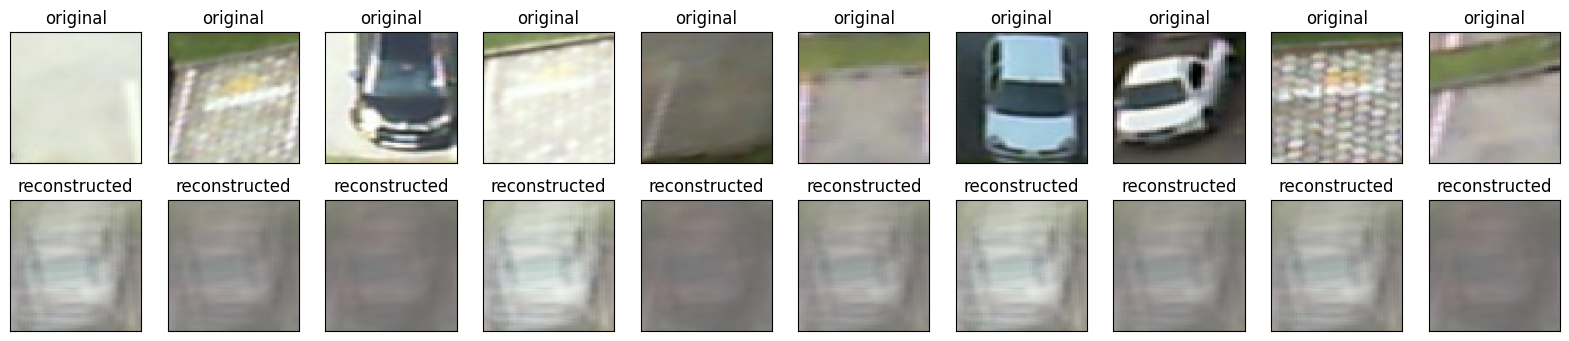

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()